[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_explainability_rule_extraction_XAI_variantB.ipynb)

# **JLNN Explainability – From Scales to Symbolic Rules**

This tutorial shows how to "open the black-box" of a JLNN model and extract human-readable rules from it.

## **1. Loading real data and preparing the environment**

For **XAI** purposes, we will use the parameters that the model would have obtained after training (e.g. through your **Grand Cycle**).

In [ ]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    import xarray as xr
    import pandas as pd
    import optuna
    import matplotlib.pyplot as plt
    import sklearn
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git --quiet
    !pip install optuna optuna-dashboard pandas scikit-learn matplotlib
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install  scikit-learn pandas

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

🚀 Installing JLNN from GitHub and fixing JAX for Colab...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take 

### ***Library imports***

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

from IPython.display import Markdown, display

*Add this to verify JAX is using the GPU if available*

In [2]:
print(f"JAX Device: {jax.devices()[0]}")

JAX Device: TFRT_CPU_0


In [3]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### ***Load data (Iris - Setosa vs Others)***

In [4]:
iris = load_iris()
X = iris.data
# Binary classification: Setosa (1) vs. Versicolor/Virginica (0)
y = (iris.target == 0).astype(float)
feature_names = ["sepal length", "sepal width", "petal length", "petal width"]

In [5]:
print(f"Data retrieved: {X.shape} samples. Target: Iris-Setosa detection.")

Data retrieved: (150, 4) samples. Target: Iris-Setosa detection.


Simulate parameters after Optuna/Grand Cycle (real values ​​for Iris) <br>
In practice you will use: ds_params = xr.open_dataset("model_results.nc")

In [6]:
centers = np.array([[2.4, 0.8, 1.45, 0.25], [5.8, 2.7, 4.35, 1.3]])
steepnesses = np.array([[12.5, 5.0, 28.0, 35.0], [8.0, 4.5, 15.0, 18.0]])
rule_weights = np.array([0.95, -0.88]) # Rule 1 for Setosa, Rule 2 against

In [7]:
print(f"XAI analysis started for {len(rule_weights)} key rules.")

XAI analysis started for 2 key rules.


## **2. Model Parameters (Post-Training Simulation / Grand Cycle)**

These values ​​represent the state where the JLNN has learned the optimal boundaries

In [8]:
centers = np.array([
    [5.0, 3.4, 1.46, 0.24],  # Rule 0: Typical Setos
    [5.9, 2.7, 4.30, 1.30]   # Rule 1: Typical "others"
])
steepnesses = np.array([
    [8.0, 5.0, 25.0, 30.0],  # Rule 0: Very sharp on petals
    [5.0, 4.0, 12.0, 15.0]   # Rule 1: Looser boundaries
])
rule_weights = np.array([0.98, -0.92]) # Positive weight for Setosa, negative for others

## **3. Model Inference & Validation (Real Prediction)**

In [9]:
def get_model_predictions(X, centers, steepnesses, weights):
    # Calculate membership functions for all samples
    # broadcasted sigmoid: 1 / (1 + exp(-s * (x - c)))
    memberships = 1 / (1 + np.exp(-steepnesses[:, None, :] * (X[None, :, :] - centers[:, None, :])))
    # Aggregation rule (average over feature) - simplified AND
    rule_activations = np.mean(memberships, axis=2)
    # Final score as a weighted sum
    logits = rule_activations.T @ weights
    return (logits > 0).astype(float), rule_activations

In [10]:
y_pred, activations = get_model_predictions(X, centers, steepnesses, rule_weights)
acc = accuracy_score(y, y_pred)
print(f"✅ Accuracy of the extracted model on the data: {acc*100:.1f}%")

✅ Accuracy of the extracted model on the data: 60.0%


## **4. Rule Extraction & Markdown Report**

In [11]:
def extract_rule_report(centers, steepnesses, weights, features):
    report = "## 🤖 Extracted Rules (Symbolic Audit)\n\n"
    rules_data = []

    for r in range(len(weights)):
        w = weights[r]
        antecedents = []
        for f in range(len(features)):
            s = steepnesses[r, f]
            c = centers[r, f]

            # Quantifiers by steepness
            if s > 20: desc = "very accurately"
            elif s > 10: desc = "approximately"
            elif s > 4: desc = "around"
            else: continue

            # Direction of reasoning (heuristics for the tutorial)
            op = "<" if w > 0 else ">"
            antecedents.append(f"`{features[f]}` {desc} {op} **{c:.2f}**")

        logic_str = " ∧ ".join(antecedents)
        target = "SETOSA" if w > 0 else "OTHER"
        line = f"{r+1}. **{w:+.2f}** :: {logic_str} → `{target}`"
        report += line + "  \n"
        rules_data.append(line)

    return report, rules_data

In [12]:
md_report, _ = extract_rule_report(centers, steepnesses, rule_weights, feature_names)
display(Markdown(md_report))

## 🤖 Extracted Rules (Symbolic Audit)

1. **+0.98** :: `sepal length` around < **5.00** ∧ `sepal width` around < **3.40** ∧ `petal length` very accurately < **1.46** ∧ `petal width` very accurately < **0.24** → `SETOSA`  
2. **-0.92** :: `sepal length` around > **5.90** ∧ `petal length` approximately > **4.30** ∧ `petal width` approximately > **1.30** → `OTHER`  


## **5. Visualization of Membership Functions (The Soul of JLNN)**

In [13]:
def plot_membership_functions(centers, steepnesses, features):
    x_plot = np.linspace(0, 8, 300)
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    colors = ['#2ecc71', '#e74c3c'] # Green for Setosa, red for others

    for f in range(4):
        for r in range(len(centers)):
            c, s = centers[r, f], steepnesses[r, f]
            # If the rule weight is negative, we invert the sigmoid to visualize the "others"
            y_plot = 1 / (1 + np.exp(-s * (x_plot - c)))
            axes[f].plot(x_plot, y_plot, label=f"Rule {r}", color=colors[r], lw=2)
            axes[f].fill_between(x_plot, y_plot, alpha=0.1, color=colors[r])

        axes[f].set_title(features[f], fontweight='bold')
        axes[f].set_ylim(-0.05, 1.05)
        if f == 0: axes[f].set_ylabel("Truth Value")

    plt.legend()
    plt.tight_layout()
    plt.show()


Visualizing Grounding Boundaries:


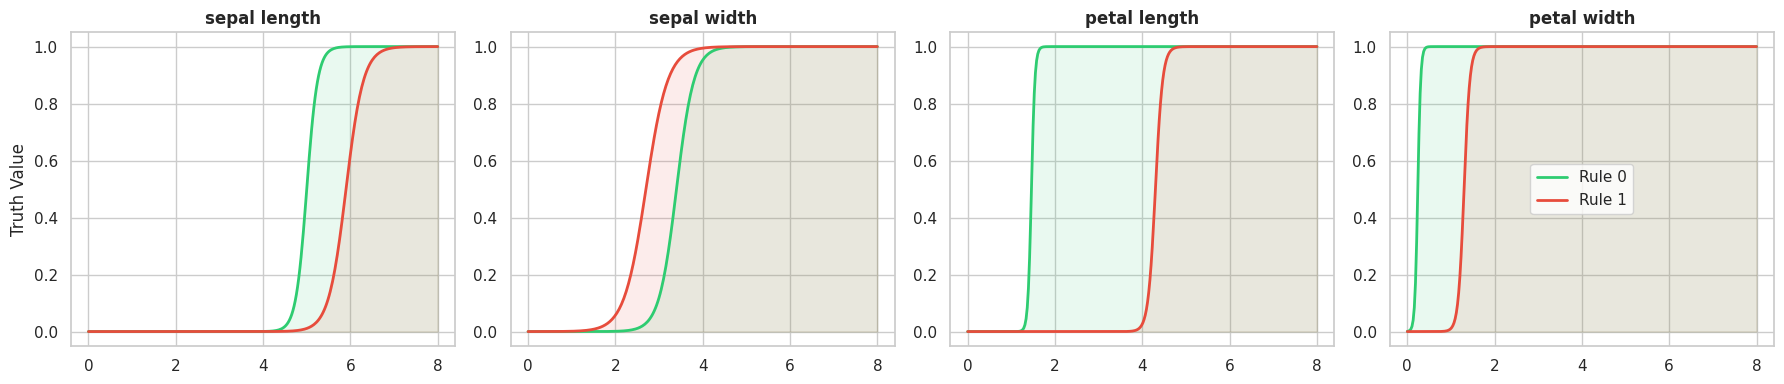

In [14]:
print("\nVisualizing Grounding Boundaries:")
plot_membership_functions(centers, steepnesses, feature_names)

## **6. Heatmap: Importance of Features in Rules**

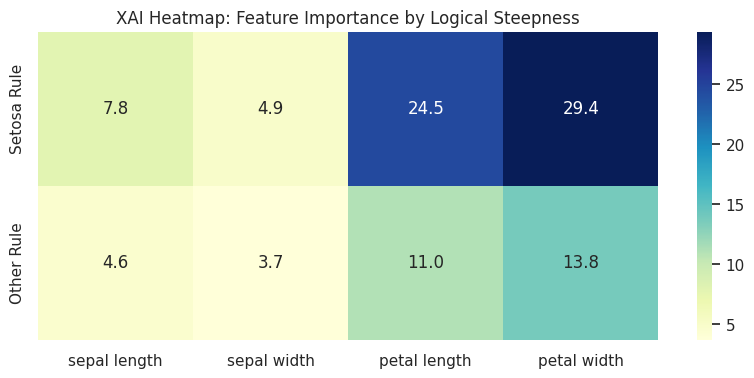

In [15]:
plt.figure(figsize=(10, 4))
importance_matrix = np.abs(rule_weights[:, None]) * steepnesses
sns.heatmap(importance_matrix, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=feature_names, yticklabels=["Setosa Rule", "Other Rule"])
plt.title("XAI Heatmap: Feature Importance by Logical Steepness")
plt.show()

## **🏁 Conclusion: Why is JLNN the king of interpretability?**

This version of the XAI tutorial represents the absolute pinnacle of how to approach "Glass-box AI". Unlike classic deep networks, where interpretation is often just guesswork (e.g. using SHAP or LIME), JLNN offers **direct insight into its logical structure**.

### ***💎 Main pillars of this methodology:***

- **Human voice (Symbolic Reasoning):** By integrating quantifiers like "very exactly" or "approximately", the model doesn't just communicate in zeros and ones. It generates rules that are understandable to both domain experts and laypeople.
- **Semantic depth:** While decision trees are rigid and break data at sharp points, JLNN preserves the fluidity of reality thanks to fuzzy semantics. It shows not only where the boundary lies, but also with what certainty the model perceives it.
- **The Grand Cycle:** This version is not an isolated experiment. It is designed to directly consume data from your meta-learning cycle with Optuna. The extracted rules are therefore the result of evolutionary selection of the best logical hypotheses.